### Implementation of [Deep Layout Parsing](https://layout-parser.readthedocs.io/en/latest/example/deep_layout_parsing/index.html)

In [1]:
import cv2
import layoutparser as lp
from layoutparser.models.detectron2 import catalog
import copy
import os
import requests as requests

In [2]:
def load_model(
        config_path: str = 'lp://<dataset_name>/<model_name>/config',
):

    config_path_split = config_path.split('/')
    dataset_name = config_path_split[-3]
    model_name = config_path_split[-2]

    # get the URLs from the MODEL_CATALOG and the CONFIG_CATALOG 
    # (global variables .../layoutparser/models/detectron2/catalog.py)
    model_url = catalog.MODEL_CATALOG[dataset_name][model_name]
    config_url = catalog.CONFIG_CATALOG[dataset_name][model_name]

    # override folder destination:
    if 'model' not in os.listdir():
        os.mkdir('model')

    config_file_path, model_file_path = None, None

    for url in [model_url, config_url]:
        filename = url.split('/')[-1].split('?')[0]
        save_to_path = f"model/" + filename
        if 'config' in filename:
            config_file_path = copy.deepcopy(save_to_path)
        if 'model_final' in filename:
            model_file_path = copy.deepcopy(save_to_path)

        # skip if file exist in path
        if filename in os.listdir("model"):
            continue
        # Download file from URL
        r = requests.get(url, stream=True, headers={'user-agent': 'Wget/1.16 (linux-gnu)'})

        with open(save_to_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=4096):
                if chunk:
                    f.write(chunk)


    return lp.models.Detectron2LayoutModel(
        config_path=config_file_path,
        model_path=model_file_path,
        extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
        label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}
    )

In [3]:
# Load the image
image = cv2.imread(f"image.png")
image = image[...,::-1] # Convert the image from BGR to RGB

# Load the model
model = load_model('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config')
layout = model.detect(image)

/home/hitesh/Projects/layoutparser-detectron2/venv/lib/python3.8/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.lo

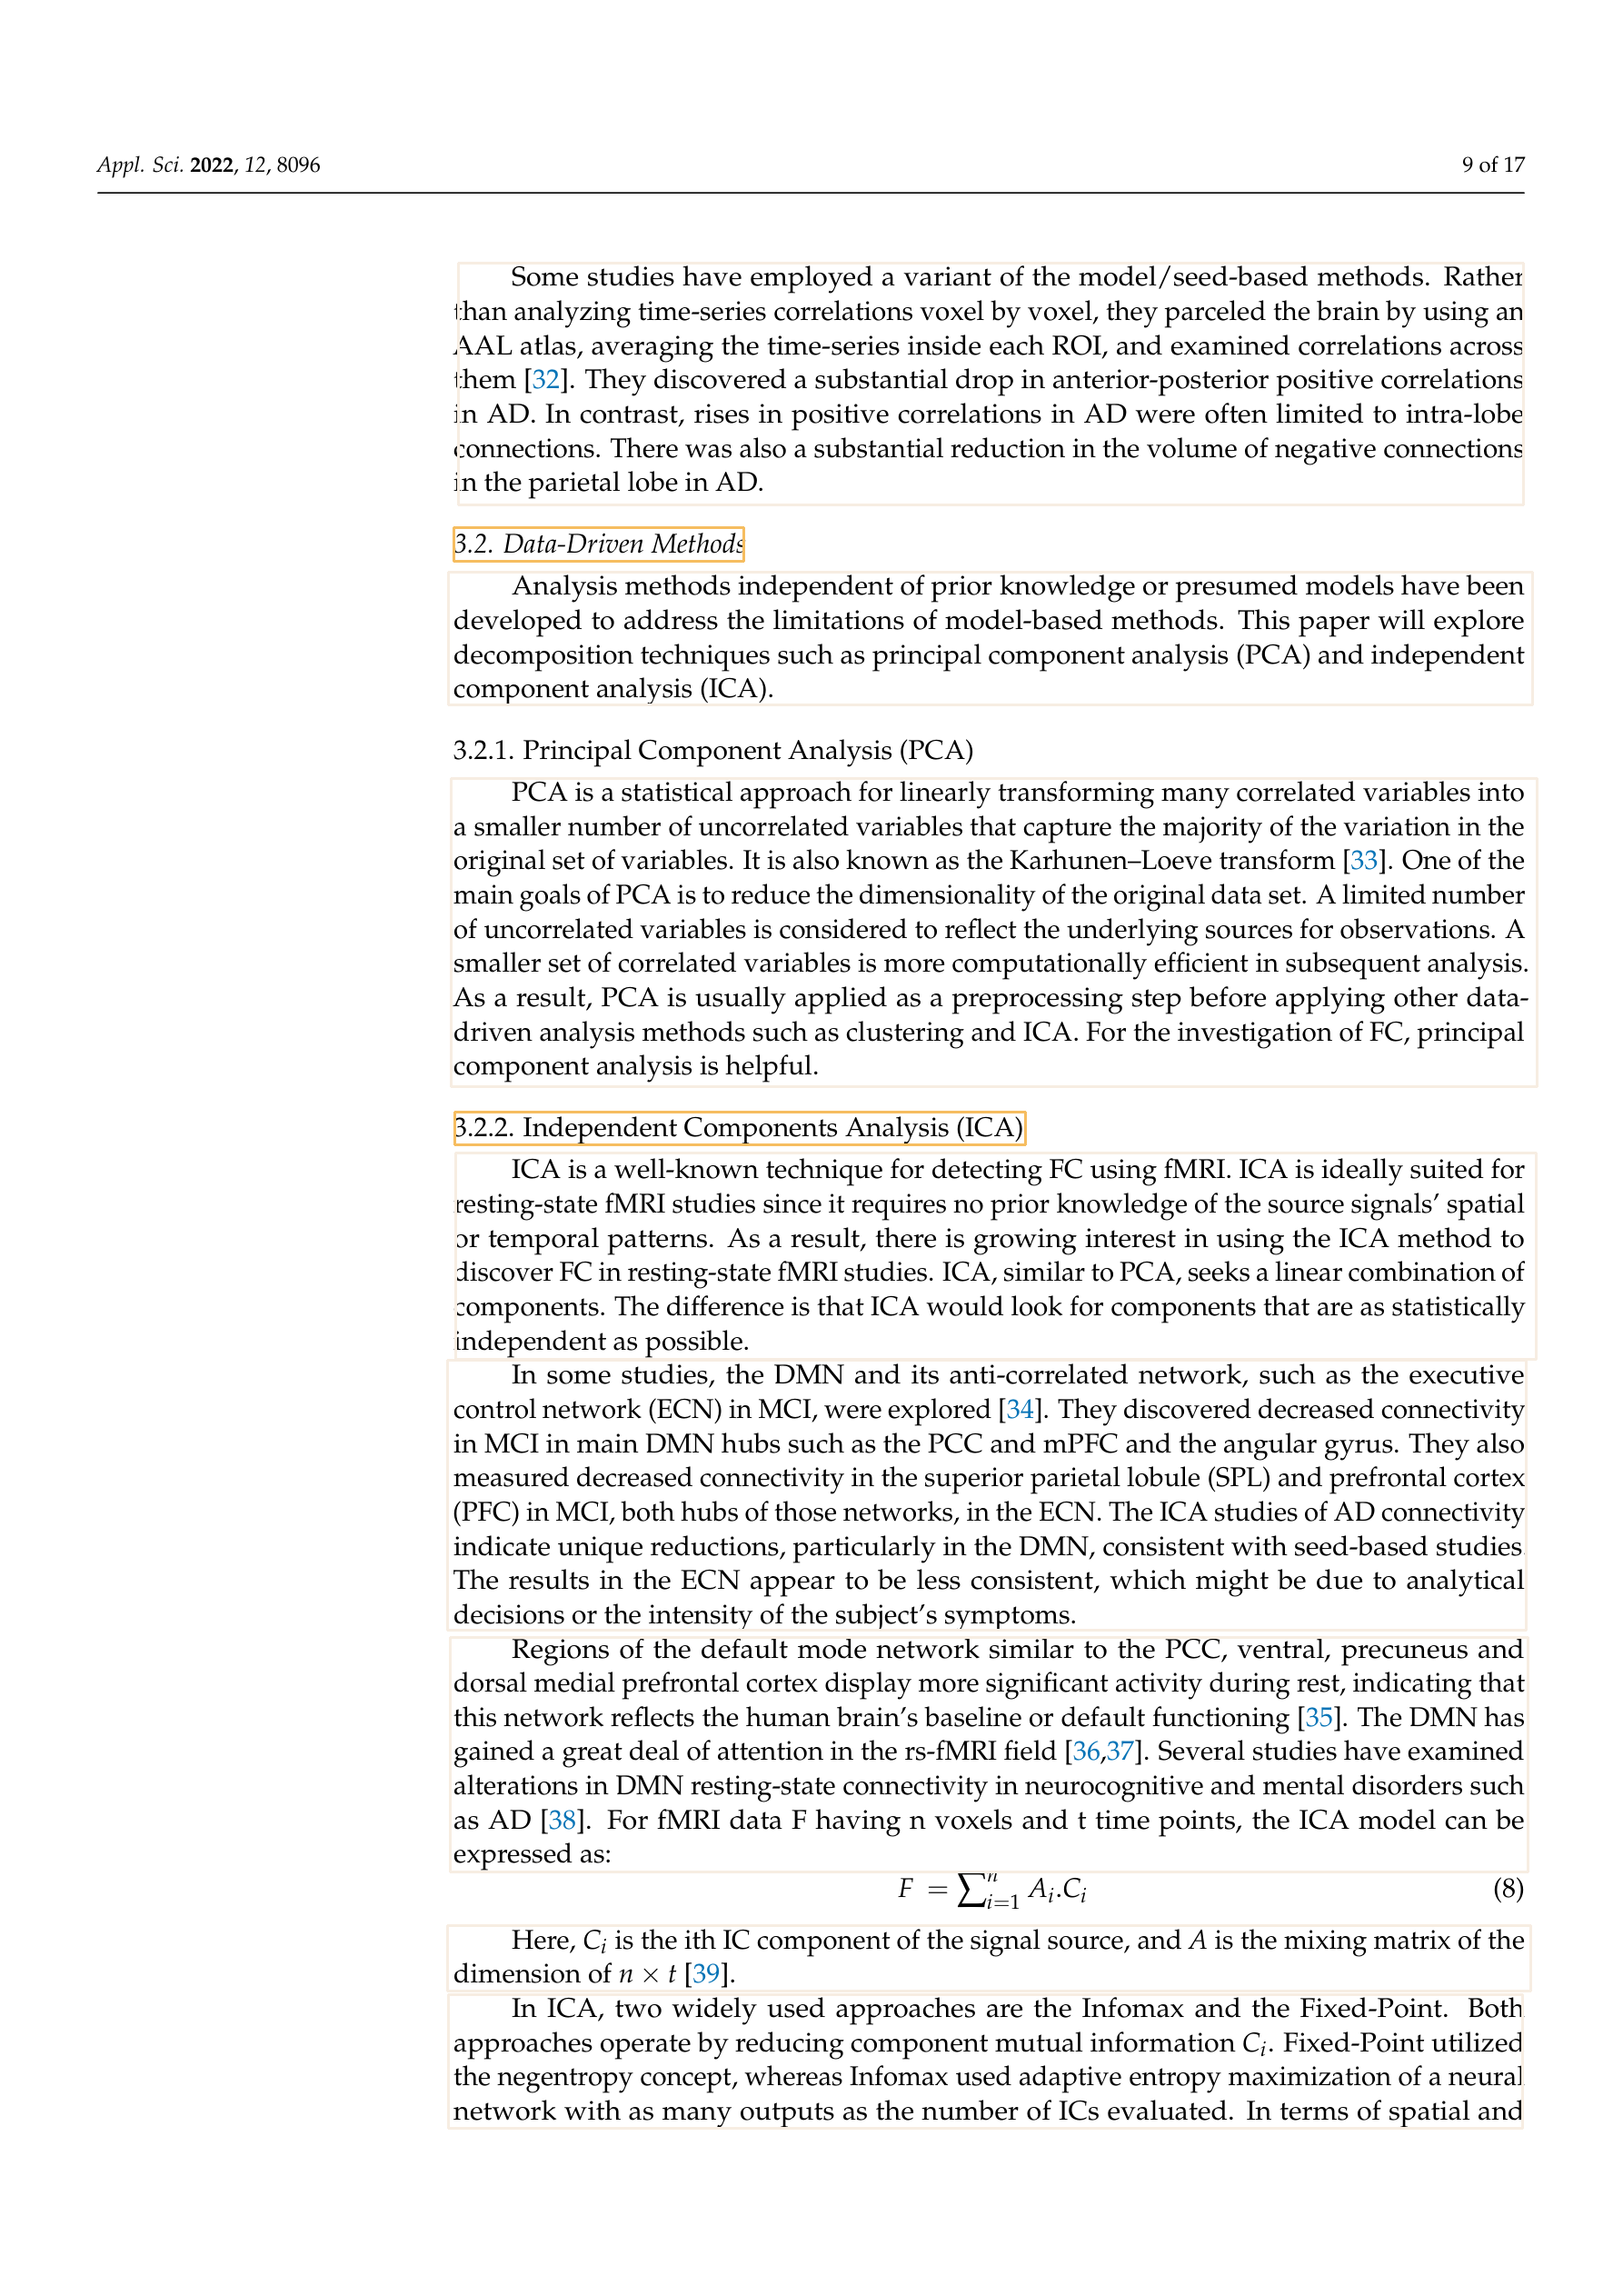

In [4]:
lp.draw_box(image, layout, box_width=3) # Show the detected layout of the input image

In [5]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

text_blocks = lp.Layout([b for b in text_blocks \
                if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

right_blocks = [b for b in text_blocks if b not in left_blocks]
right_blocks.sort(key = lambda b:b.coordinates[1])

# And finally combine the two list and add the index
# according to the order
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])

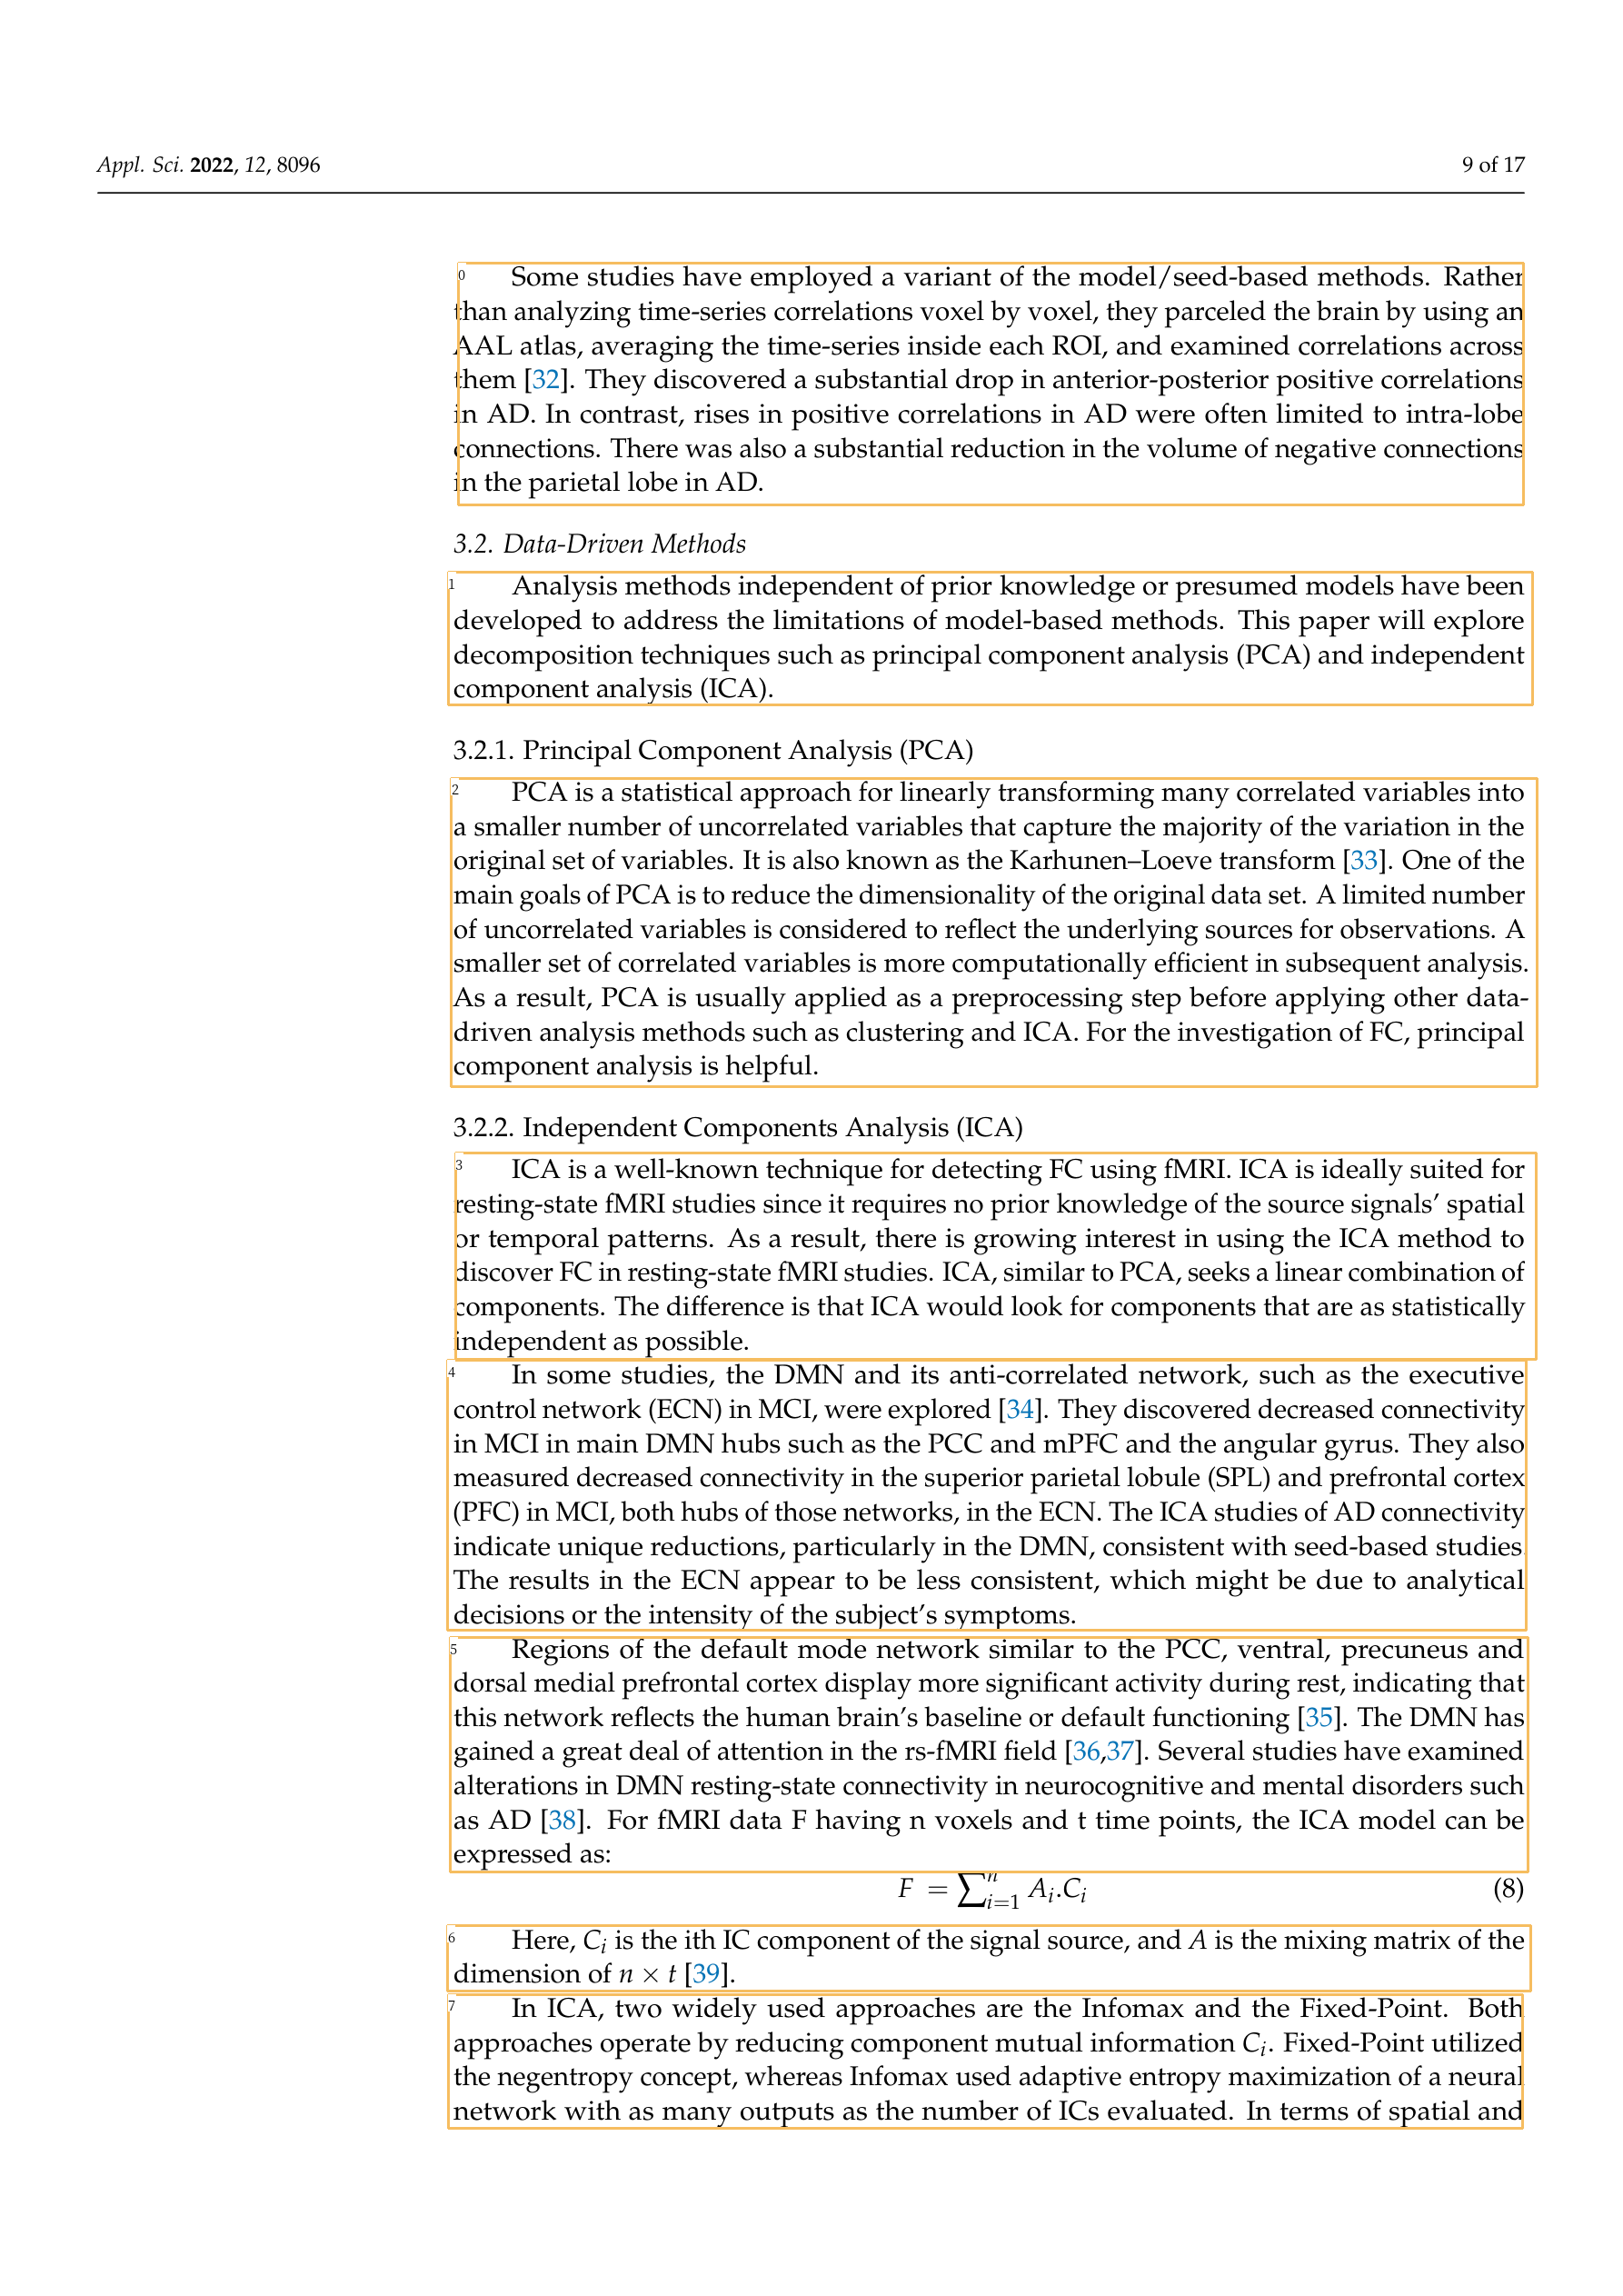

In [6]:
lp.draw_box(image, text_blocks,
            box_width=3,
            show_element_id=True)

In [7]:
ocr_agent = lp.TesseractAgent(languages='eng')
for block in text_blocks:
    segment_image = (block
                    .pad(left=5, right=5, top=5, bottom=5)
                    .crop_image(image))
        # add padding in each image segment can help
        # improve robustness

    text = ocr_agent.detect(segment_image)
    block.set(text=text, inplace=True)

for txt in text_blocks.get_texts():
    print(txt, end='\n---\n')

Some studies have employed a variant of the model/seed-based methods. Rather
than analyzing time-series correlations voxel by voxel, they parceled the brain by using an
AAL atlas, averaging the time-series inside each ROI, and examined correlations across
them [32]. They discovered a substantial drop in anterior-posterior positive correlations
in AD. In contrast, rises in positive correlations in AD were often limited to intra-lobe
connections. There was also a substantial reduction in the volume of negative connections
in the parietal lobe in AD.

---
Analysis methods independent of prior knowledge or presumed models have been
developed to address the limitations of model-based methods. This paper will explore
decomposition techniques such as principal component analysis (PCA) and independent
component analysis (ICA).

---
PCA is a statistical approach for linearly transforming many correlated variables into
a smaller number of uncorrelated variables that capture the majority of the